# Imports

In [1]:
import numpy             as np
import pandas            as pd
import pickle
import seaborn           as sns
import psycopg2          as pg
import scikitplot        as skplt
import matplotlib.pyplot as plt

from IPython.display     import Image
from scipy               import stats           as ss
from sklearn             import preprocessing   as pp
from sklearn             import model_selection as ms
from sklearn             import ensemble        as en
from sklearn             import neighbors       as nh
from sklearn             import linear_model    as lm
from lightgbm            import LGBMClassifier

In [2]:
# # configurações globais
# sns.set_theme()                                                   # gráfico
# plt.rcParams['figure.figsize'] = [20, 12]                         # gráfico

## Funções

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y) # tabela de contingência, necessária para calcular o chi2

    chi2 = ss.chi2_contingency(cm)[0]  #chi2_contingency calcula 4 coisas, queremos só a primeira.

    n = cm.sum().sum() # o primeiro sum() soma os elementos de todas as colunas, o segundo soma todas as somas anteriores
    r, k = cm.shape  # r: linhas, k: colunas de cm

    # correção do viés

    phi2_til = max(0, chi2/n - (k-1)*(r-1)/(n-1))
    k_til = k - ((k-1)**2)/(n-1)
    r_til = r - ((r-1)**2)/(n-1)

    v_til = np.sqrt(phi2_til/(min(k_til - 1, r_til -1)))
    
    return v_til

def precision_at_k(data, k=2000):
    # Precision Top K
    data = data.reset_index(drop=True)

    # create ranking
    data['ranking'] = data.index + 1

    # precision at k
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return data.loc[k, 'precision_at_k']


def recall_at_k(data, k=2000):
    # Recall Top K
    data = data.reset_index(drop=True)

    # create ranking
    data['ranking'] = data.index + 1

    # precision at k
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return data.loc[k, 'recall_at_k']

def performance(data, yhat, k=2000):
    # score
    data['score'] = yhat[:,1].tolist()

    # ordenação pelo score
    data = data.sort_values('score', ascending=False)

    # Precision at K
    precision_at = precision_at_k(data, k)
#     print(f'Precision at {k}: {precision_at}')

    # Recall at K
    recall_at = recall_at_k(data, k)
#     print(f'Recall at {k}: {recall_at}')

    return precision_at, recall_at
    
def cv_data_preparation(data):
    
    path = '/home/jonas/Documentos/repos/health_insurance_cross_sell/parameter/'
    age_scaler                = pickle.load(open(path + 'age_scaler.pkl', 'rb'))
    annual_premium_scaler     = pickle.load(open(path + 'annual_premium_scaler.pkl', 'rb'))
    fe_encode_policy          = pickle.load(open(path + 'fe_encode_policy.pkl', 'rb'))
    target_encode_region_code = pickle.load(open(path + 'target_encode_region_code.pkl', 'rb'))
    vintage_scaler            = pickle.load(open(path + 'vintage_scaler.pkl', 'rb'))
    target_encode_vehicle_age = pickle.load(open(path + 'target_encode_vehicle_age.pkl', 'rb'))
    
    ## annual premium
    data['annual_premium'] = annual_premium_scaler.transform(data[['annual_premium']].values)

    # age
    data['age'] = age_scaler.transform(data[['age']].values)

    # vintage 
    data['vintage'] = vintage_scaler.transform(data[['vintage']].values)

    # region_code
    data['region_code'] = data['region_code'].map(target_encode_region_code)

    # vehicle_damage
    # data = pd.get_dummies(data, prefix='vehicle_damage', columns=['vehicle_damage'])

    # policy_sales_channel
    data['policy_sales_channel'] = data['policy_sales_channel'].map(fe_encode_policy)

    # vehicle_age
    # data = pd.get_dummies(data, prefix='vehicle_age', columns=['vehicle_age'])

    # vehicle_age
    data['vehicle_age'] = data['vehicle_age'].map(target_encode_vehicle_age)

    # gender
    data['gender'] = data['gender'].apply(lambda x: 1 if x == 'Male' else 0)

    # vehicle_damage -  One Hot Encoding (escolhido) / Frequency Encoding / Target Encoding / Weight Target Encoding
    data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

    data = data.fillna(0)
    
    return data

def cross_validation(data, model, model_name, iterations=5):

    df_performance = pd.DataFrame()

    for i in range(iterations):

        X = data.drop('response', axis=1)
        y = data['response'].copy()

        X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2)

        df5 = pd.concat([X_train, y_train], axis=1)

        df5 = cv_data_preparation(df5)
        X_test = cv_data_preparation(X_test)

        X_test2 = X_test.copy()

        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured', 'vehicle_age']

        X_train = df5[cols_selected]
        X_test = X_test[cols_selected]
        
        # model
        model_predict = model
        
        # model training
        model_predict.fit(X_train, y_train)

        # predict
        yhat = model_predict.predict_proba(X_test)

        # data copy
        df8 = pd.concat([X_test2['id'], X_test], axis=1)
        df8['response'] = y_test.copy()
        df8 = df8.reset_index(drop=True)

        #performance
        precision_at, recall_at = performance(df8, yhat, k=2000)

        df_aux = pd.DataFrame({'precision': precision_at, 'recall': recall_at}, index=[0])

        df_performance = pd.concat([df_performance, df_aux])
        
    df_cv = pd.DataFrame({'Modelo': model_name, 
                          'Precision at 2000 CV': str(round(df_performance['precision'].mean(), 4)) + ' +/- ' + str(round(df_performance['precision'].std(), 4)),
                          'Recall at 2000 CV': str(round(df_performance['recall'].mean(), 4)) + ' +/- ' + str(round(df_performance['recall'].std(), 4))}, index=[0])

    return df_cv




# 1 Análise Descritiva

In [4]:
#df2 = pd.read_csv('datasets/data_raw.csv')
df2 = pd.read_csv('datasets/train.csv')
df2.columns = df2.columns.str.lower()

In [243]:
df2.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 1.1 Dimensões dos dados

In [244]:
print(f'Linhas: {df2.shape[0]}')
print(f'Colunas: {df2.shape[1]}')

Linhas: 381109
Colunas: 12


## 1.2 Tipos das Variáveis

In [245]:
df2.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 1.3 Checagem de NA's

In [246]:
df2.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 1.4 Estatística Descritiva

In [247]:
num_attributes = df2.select_dtypes(include=['int64', 'float64'])

# Central Tendency
# média
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
# mediana
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion Tendency
dt1 = pd.DataFrame(num_attributes.apply(np.std)).T
dt2 = pd.DataFrame(num_attributes.apply(min)).T
dt3 = pd.DataFrame(num_attributes.apply(max)).T
dt4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
dt5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
dt6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

df_statistic = pd.concat([dt2, dt3, dt4, ct1, ct2, dt1, dt5, dt6]).T.reset_index()

# Renomeando as colunas
df_statistic.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

df_statistic

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


In [248]:
df2.describe()

,id,age,driving_license,region_code,previously_insured,annual_premium,policy_sales_channel,vintage,response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,190555.000000,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,110016.836208,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,1.000000,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,95278.000000,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,190555.000000,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,285832.000000,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,381109.000000,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


In [249]:
df2_cat = df2.select_dtypes(include=['object'])
df2_cat.head()

,gender,vehicle_age,vehicle_damage
0,Male,> 2 Years,Yes
1,Male,1-2 Year,No
2,Male,> 2 Years,Yes
3,Male,< 1 Year,No
4,Female,< 1 Year,No


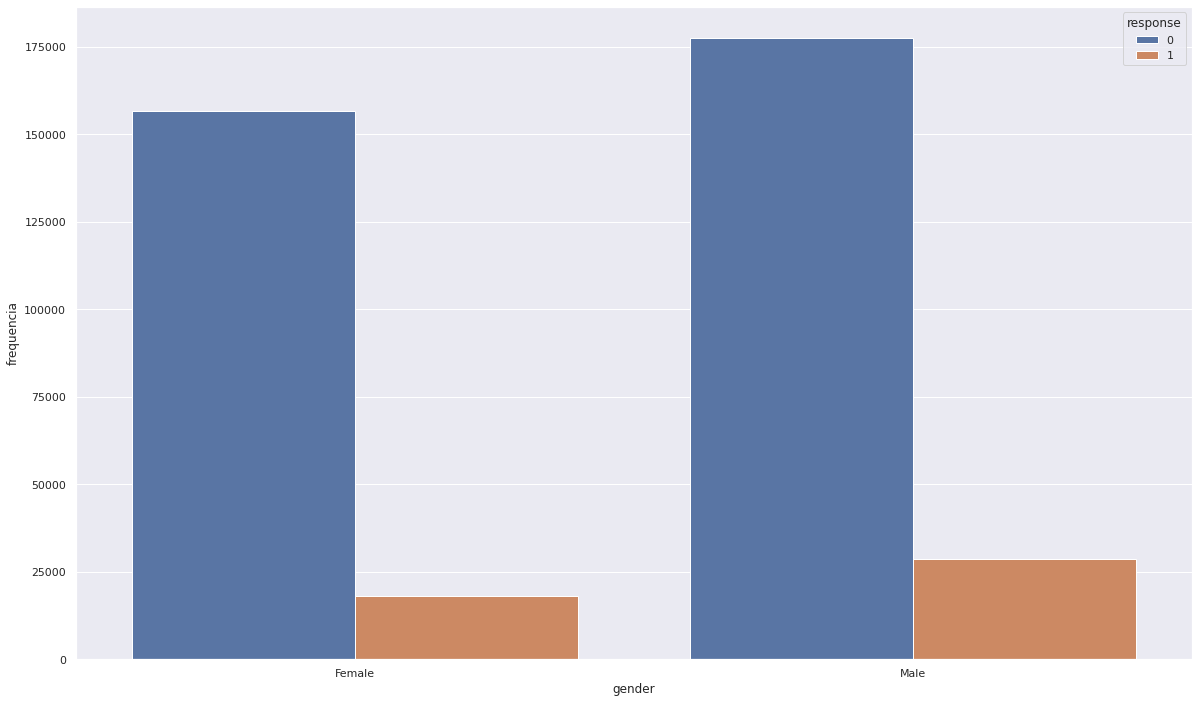

In [251]:
# gender x response
df_aux = df2[['id', 'gender', 'response']].groupby(['gender', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='gender', y='frequencia', hue='response');

<AxesSubplot:xlabel='vehicle_age', ylabel='frequencia'>

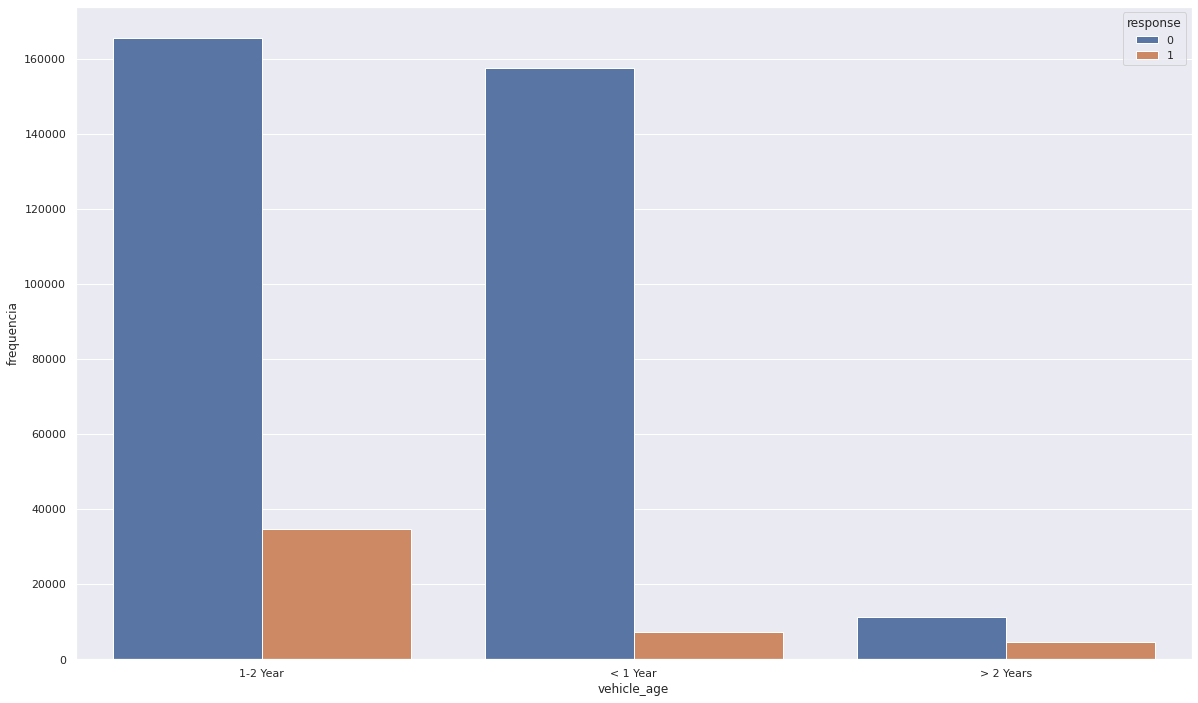

In [252]:
# vehicle_age x response
df_aux = df2[['vehicle_age', 'response', 'id']].groupby(['vehicle_age', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='vehicle_age', y='frequencia', hue='response')

<AxesSubplot:xlabel='vehicle_damage', ylabel='frequencia'>

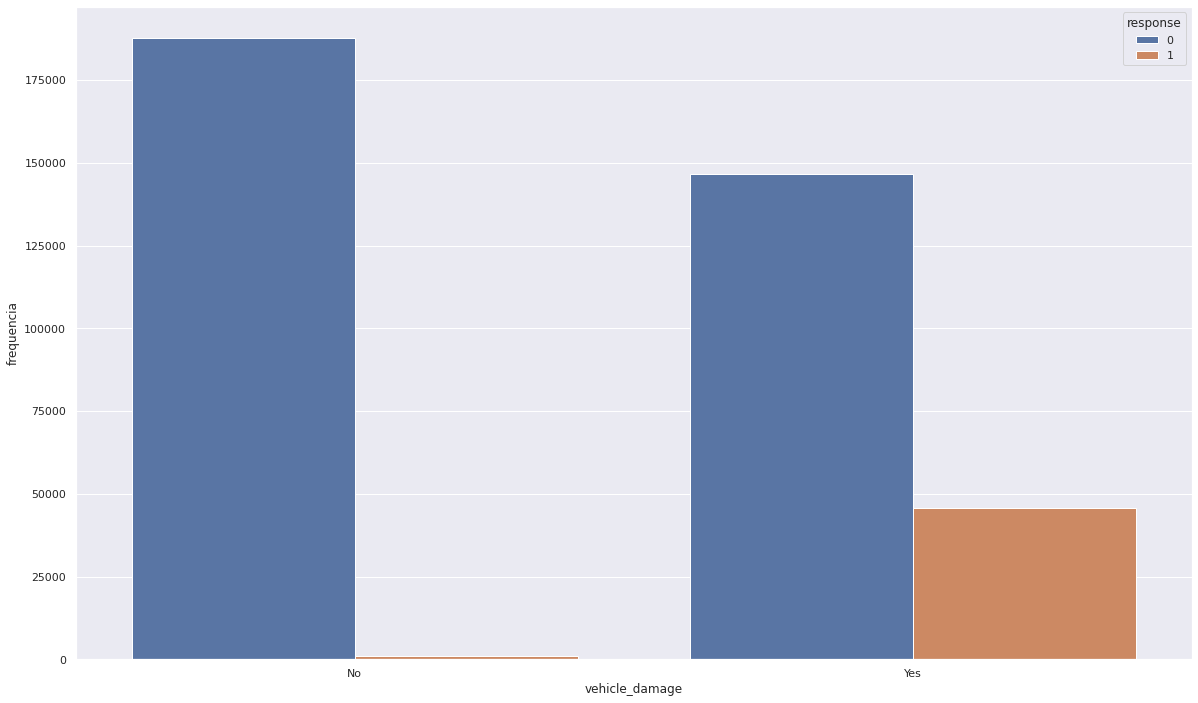

In [253]:
# vehicle_damage x response
df_aux = df2[['vehicle_damage', 'response', 'id']].groupby(['vehicle_damage', 'response']).count().reset_index()
df_aux['frequencia'] = df_aux['id']
sns.barplot(data=df_aux, x='vehicle_damage', y='frequencia',hue='response')

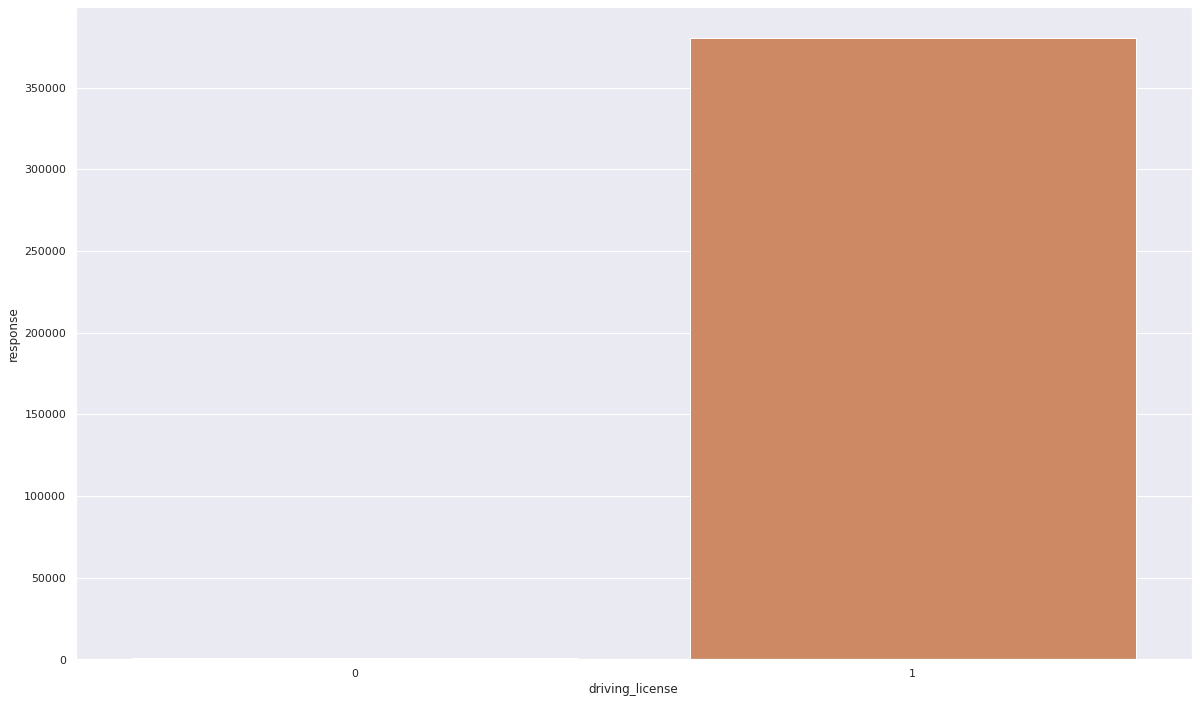

In [254]:
# driving_license x response
df_aux = df2[['driving_license', 'response']].groupby('driving_license').count().reset_index()
sns.barplot(data=df_aux, x='driving_license', y='response');

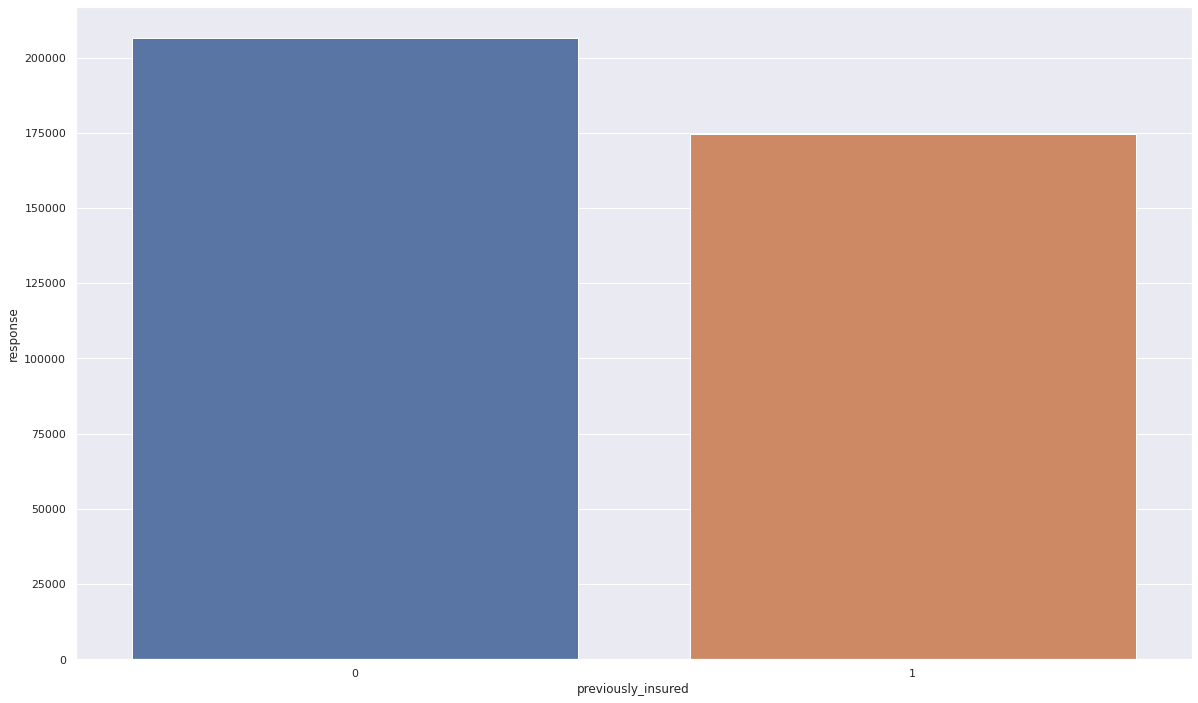

In [255]:
# previously_insured x response
df_aux = df2[['previously_insured', 'response']].groupby('previously_insured').count().reset_index()
sns.barplot(data=df_aux, x='previously_insured', y='response');

Conclusões:

- A maior parte dos clientes não tem interesse em obter o seguro.
- De todos os clientes, a maioria possui menos de um ano de seguro de vida.
- Mais de 50% dos clientes não possuem seguro de automóvel.
- Praticamente todos possuem habilitação para dirigir.
- Maioria é masculina
- A maioris dos veículos são novos, menos de 1 ano.

# 2 Feature Engineering

In [5]:
df3 = df2.copy()

## 2.1 Mapa Mental de Hipóteses

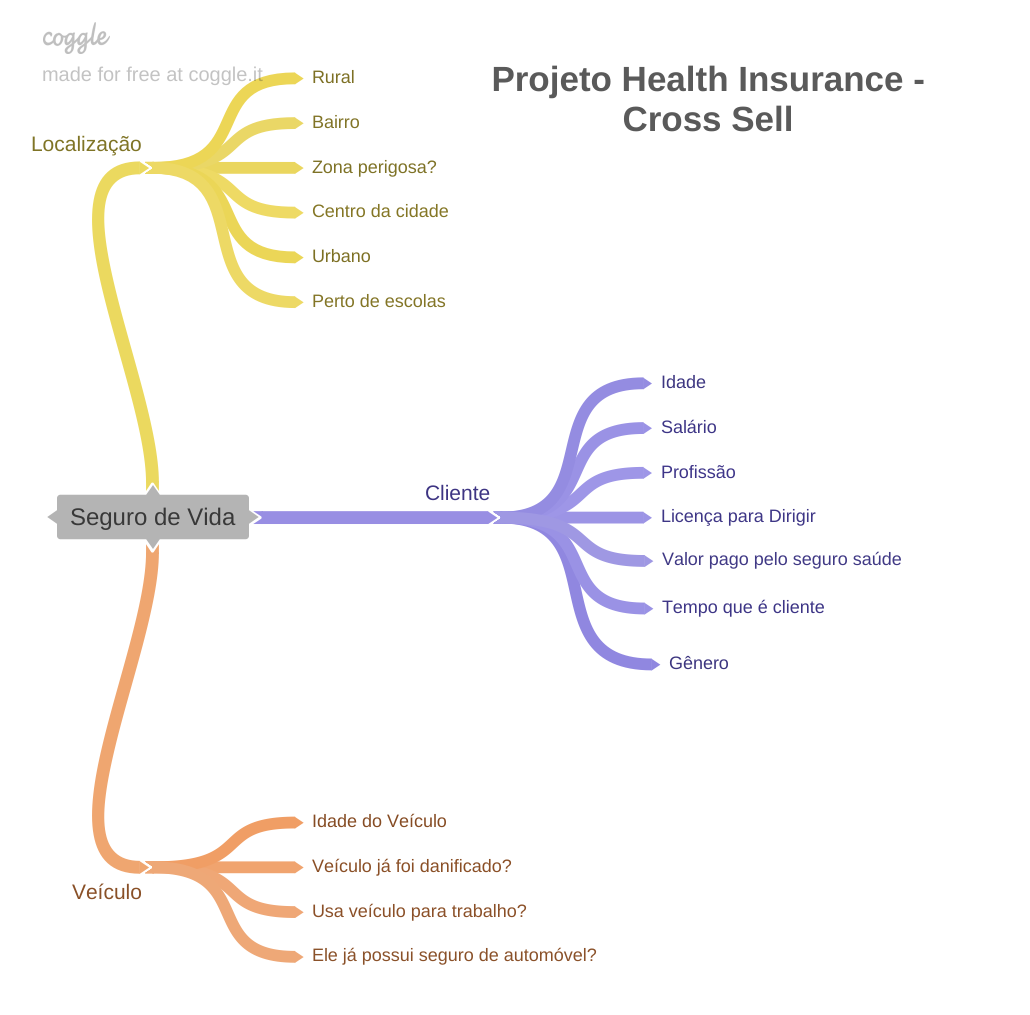

In [6]:
Image('images/Seguro_de_Vida.png')

## 2.2 Criação de Hipóteses

### 2.2.1 Clientes

**H1**: Clientes mais velhos tem mais interesse em obter seguro de automóvel.

**H2**: Clientes mulheres tem mais interesse em obter seguro de automóvel.

**H3**: Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.

**H4**: Clientes que pagaram mais pelo seguro de vida possuem mais interesse em obter seguro de automóvel.

**H5**: Clientes mais antigos possuem mais interesse em obter seguro de automóivel.

### 2.2.2 Veículo

**H6**: Clientes com veículos mais antigos tem menos interesse em obter seguro de automóvel.

**H7**: Clientes com veículos que já foram danificados tem mais interesse em obter seguro de automóvel.

**H8**: Clientes que já possuem seguro de automóvel em outra seguradora possuem menos interesse em obter seguro de automóvel.

**H9**: Clientes que usam o carro para trabalhar possuem mais interesse em obter seguro de automóvel.

### 2.2.3 Localização

Nesse ciclo não temos grandes informações sobre as localizações dos clientes, então não serão expĺoradas hipóteses de negócios para esse atributo. Mas, algumas hipóteses que poderiam ser levantadas, seriam:

**H10**: Clientes que moram na zona urbana possuem mais interesse em obter seguro de automóvel.

**H11**: Clientes que moram em área periféricas possuem menos interesse em obter seguro de automóvel.

**H12**: Clientes que moram em área perto a escolas possuem mais interesse em obter seguro de automóvel.

## 2.3 Feature Engineering

In [7]:
# CICLO 1
# # gender
# df3['gender'] = df3['gender'].apply(lambda x: '0' if x == 'Male' else '1')

# # vehicle_age
# df3['vehicle_age'] = df3['vehicle_age'].apply(lambda x: 0.5 if x == '< 1 Year' else 
#                                                         1.5 if x == '1-2 Year' else
#                                                         2.5)

# # vehicle damage
# df3['vehicle_damage'] = df3['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

In [8]:
# CICLO 2
# vehicle_age
df3['vehicle_age'] = df3['vehicle_age'].apply(lambda x: 'less_than_1' if x == '< 1 Year' else 
                                                        'between_1_2' if x == '1-2 Year' else
                                                        'more_than_2')

# # vintage em anos
# df3['vintage_year'] = df3['vintage']/365

# # vintage em meses
# df3['vintage_month'] = df3['vintage']/30

# # annual_premium / vintage
# df3['annual_premium_per_vintage'] = df3['annual_premium'] / df3['vintage']

# age
df3['joviality'] = df3['vintage'].apply(lambda x: 1 if x < 25 else 0)


In [7]:
df3.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,joviality
0,1,Male,44,1,28.0,0,more_than_2,Yes,40454.0,26.0,217,1,0
1,2,Male,76,1,3.0,0,between_1_2,No,33536.0,26.0,183,0,0
2,3,Male,47,1,28.0,0,more_than_2,Yes,38294.0,26.0,27,1,0
3,4,Male,21,1,11.0,1,less_than_1,No,28619.0,152.0,203,0,0
4,5,Female,29,1,41.0,1,less_than_1,No,27496.0,152.0,39,0,0


# 3 Análise Exploratória dos Dados


In [9]:
df4 = df3.copy()

## 3.1 Análise Univariada

### 4.1.1 Variável Resposta

<AxesSubplot:xlabel='response', ylabel='id'>

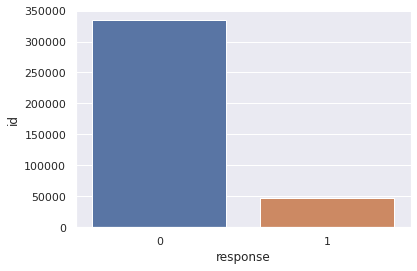

In [8]:
df_aux = df4[['id','response']].groupby('response').count().reset_index()

sns.barplot(data=df_aux, x='response', y='id')

### 4.1.2 Variáveis Numéricas

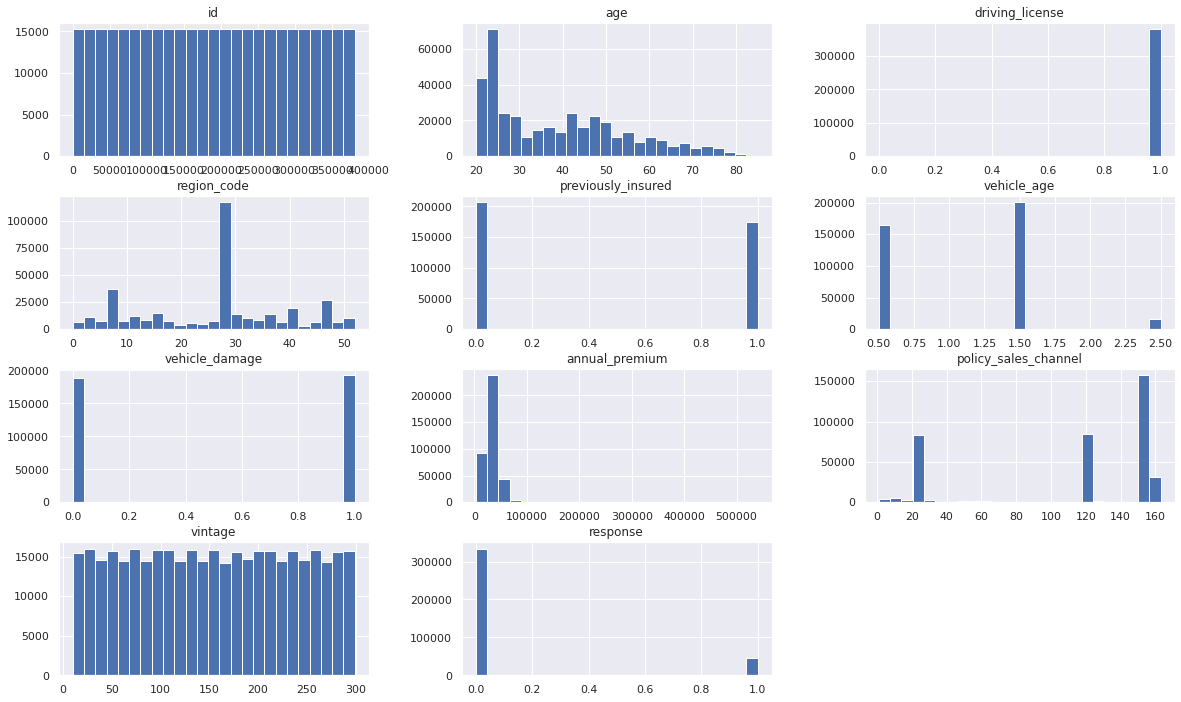

In [11]:
df4_num = df4.select_dtypes(include=['int64', 'float64'])

df4_num.hist(bins=25);

## 3.2 Análise Bivariada

### 3.2.1 H1: Clientes mais velhos tem mais interesse em obter seguro de automóvel.
**Falso**. Clientes na meia idade (entre 30 e 50 anos) possuem mais interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='age', ylabel='response'>

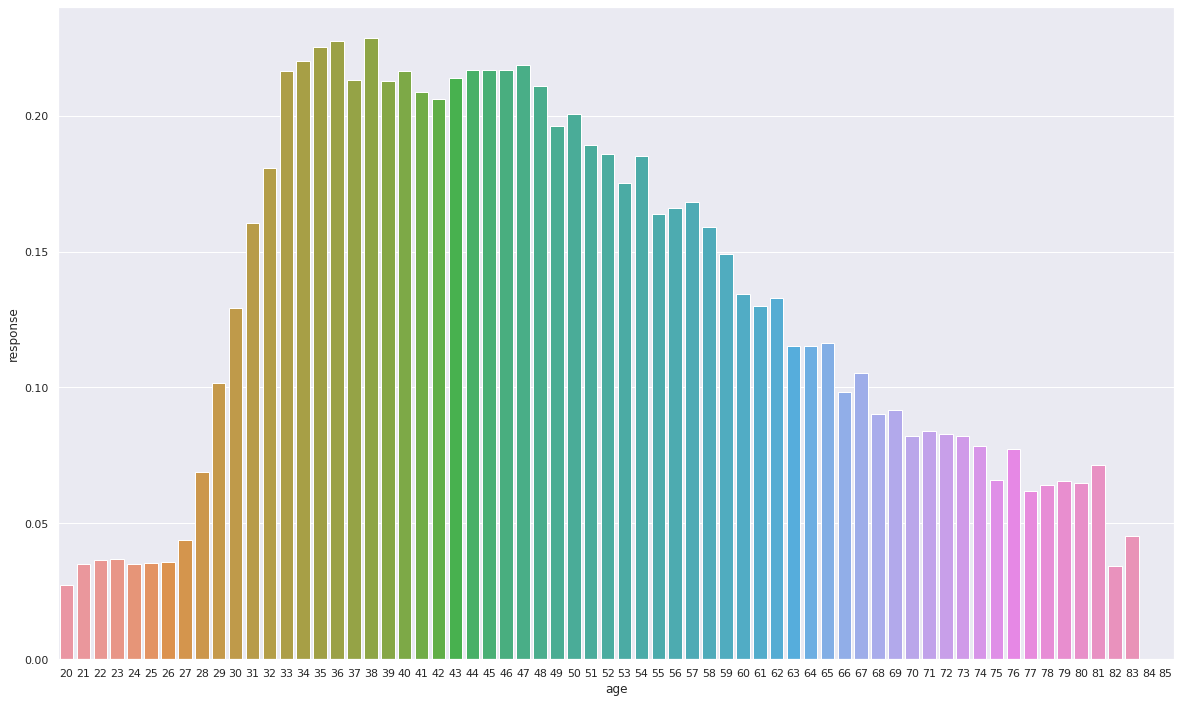

In [25]:
# age x response
df_aux = df4[['age', 'response']].groupby('age').mean().reset_index()

sns.barplot(data=df_aux, x='age', y='response')

### 3.2.2 H2: Clientes mulheres tem mais interesse em obter seguro de automóvel.
**Falso**. Clientes mulheres tem menos interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='gender', ylabel='response'>

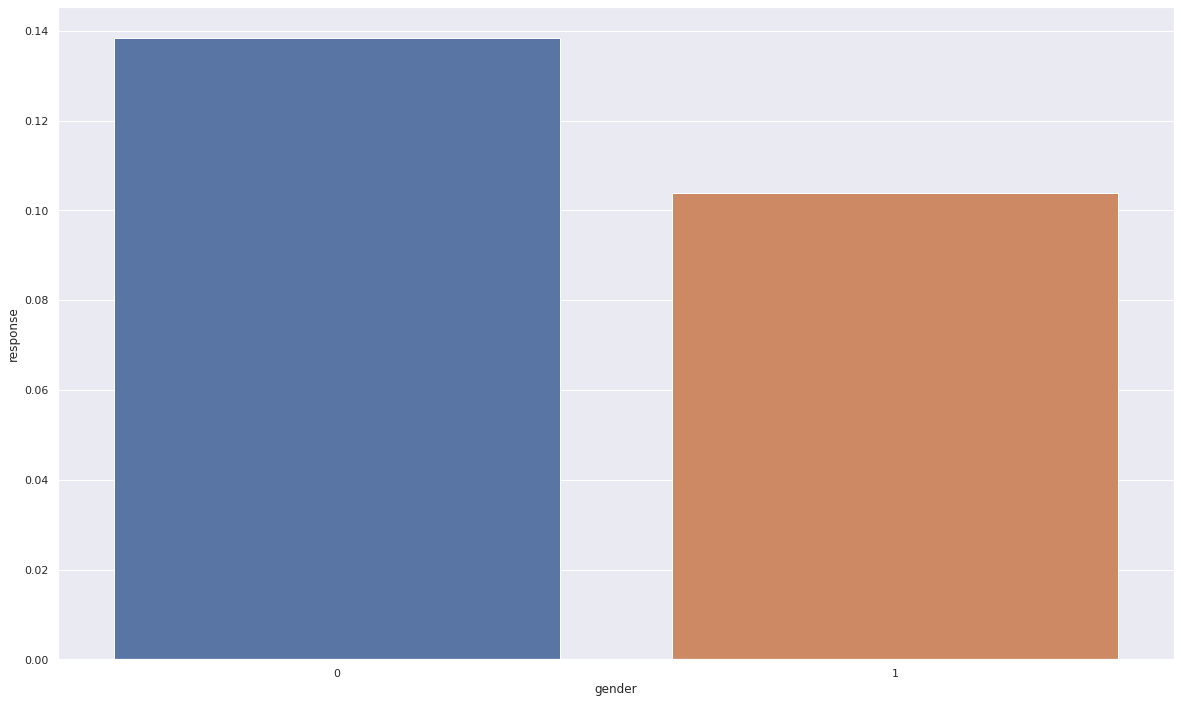

In [24]:
# gender x response
df_aux = df4[['gender', 'response']].groupby('gender').mean().reset_index()

sns.barplot(data=df_aux, x='gender', y='response')

### 3.2.3 H3: Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.
**Verdadeiro**. Clientes com licença para dirigir tem mais interesse em obter seguro de automóvel.

<AxesSubplot:xlabel='driving_license', ylabel='response'>

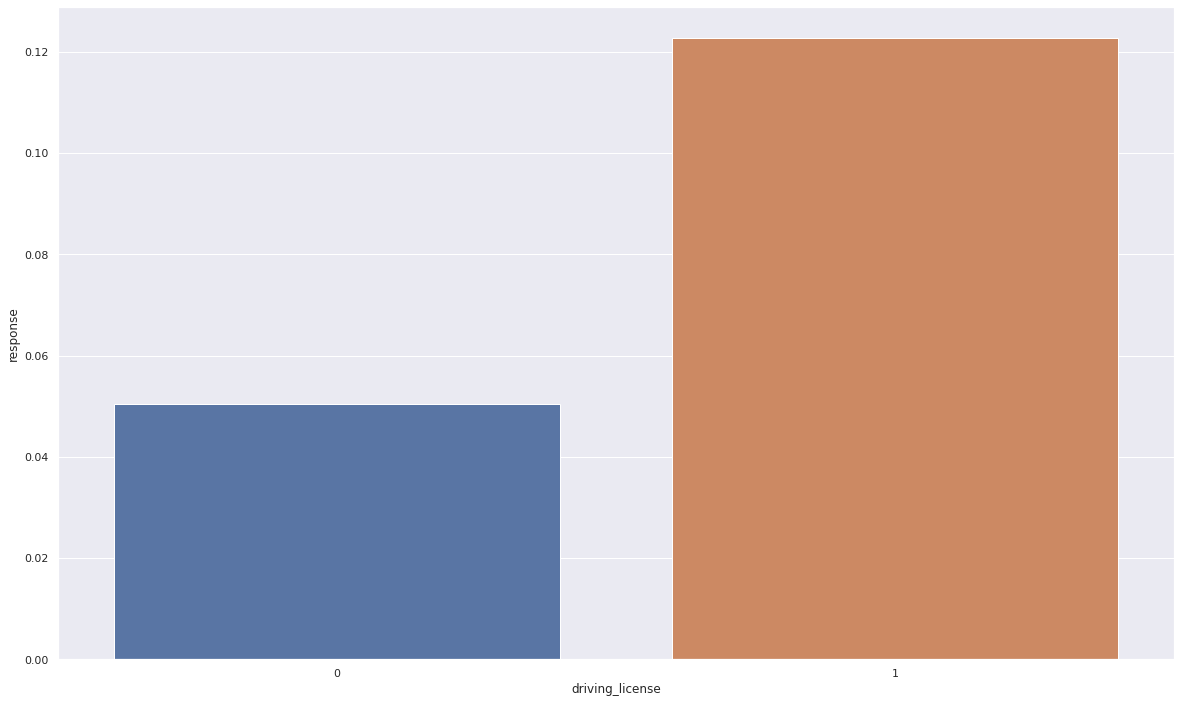

In [23]:
# driving_license x response
df_aux = df4[['driving_license', 'response']].groupby('driving_license').mean().reset_index()

sns.barplot(data=df_aux, x='driving_license', y='response')

### 3.2.4 H4: Clientes que pagaram mais pelo seguro de vida possuem mais interesse em obter seguro de automóvel.

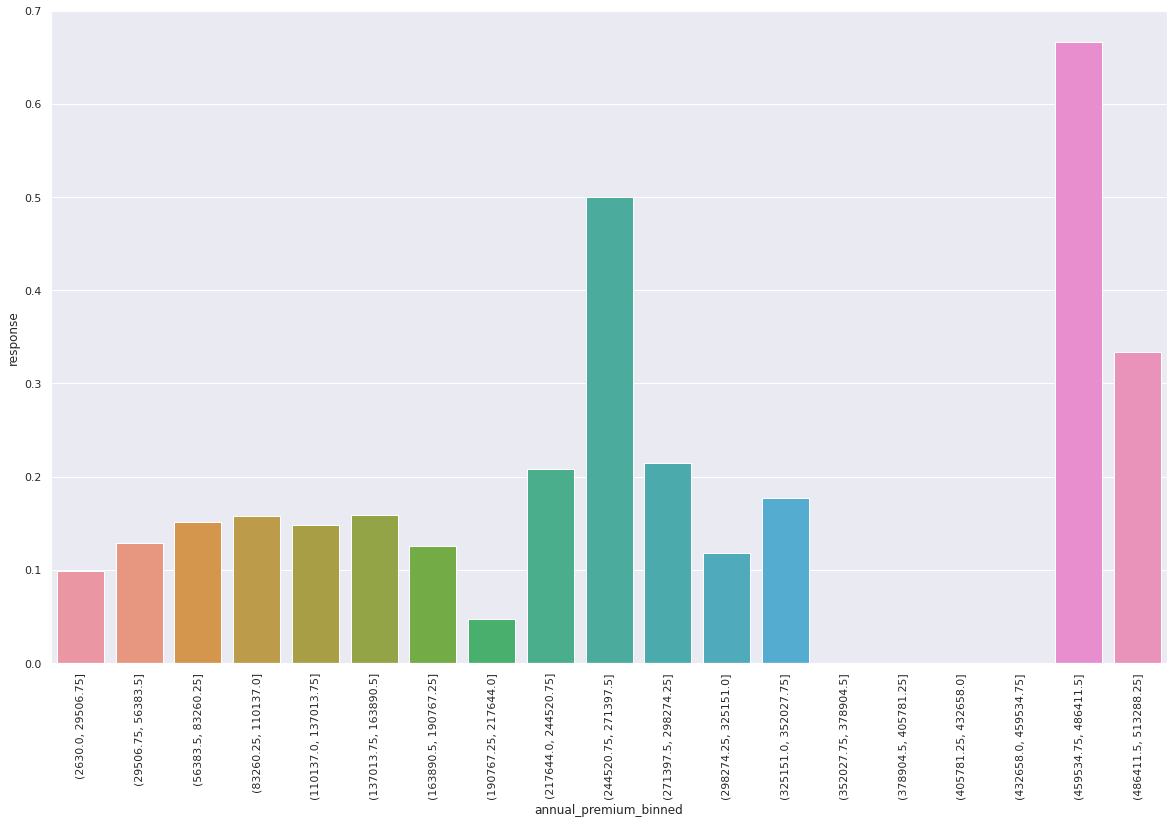

In [22]:
# annual_premium x response
# df_aux = df4[['annual_premium', 'response']].groupby('annual_premium').count().reset_index()

x0 = df4['annual_premium'].min()
xf = df4['annual_premium'].max()

b = list(np.arange(x0, xf, (xf-x0)/20))
df4['annual_premium_binned'] = pd.cut(df4['annual_premium'], bins=b)
df_aux = df4[['annual_premium_binned', 'response']].groupby('annual_premium_binned').mean().reset_index()

sns.barplot(data=df_aux, x='annual_premium_binned', y='response');
plt.xticks(rotation=90);

### 3.2.5 H5: Clientes mais antigos possuem mais interesse em obter seguro de automóvel.
**Falso** Não há diferença significativa com relação ao tempo que o cliente possui o seguro de vida.

<AxesSubplot:xlabel='response', ylabel='vintage_binned'>

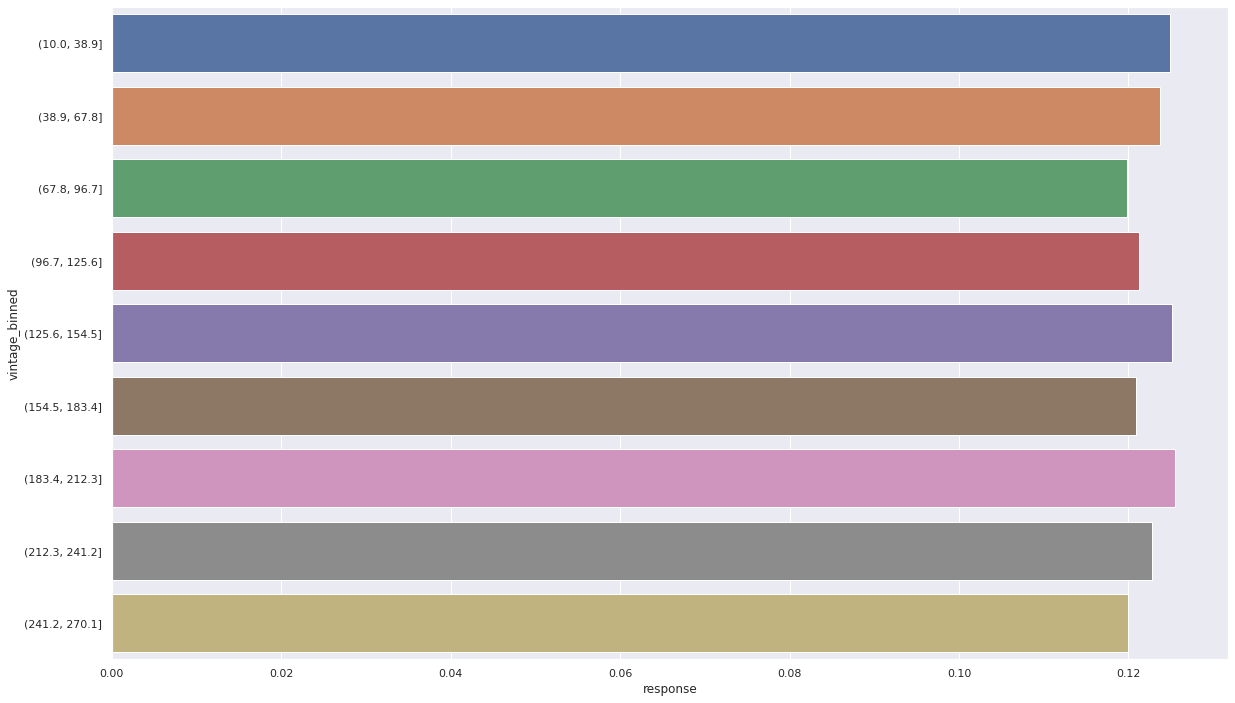

In [39]:
# vintage x response

x0 = df4['vintage'].min()
xf = df4['vintage'].max()

b = list(np.arange(x0, xf, (xf-x0)/10))
df4['vintage_binned'] = pd.cut(df4['vintage'], b)
aux = df4[['vintage_binned', 'response']].groupby('vintage_binned').mean().reset_index()

sns.barplot(data=aux, y='vintage_binned', x='response')


### 3.2.6 H6: Clientes com veículos mais antigos tem menos interesse em obter seguro de automóvel.
**Falso** Clientes com veículos mais antigos tem mais interesse em obter seguro de automóvel

<AxesSubplot:xlabel='vehicle_age', ylabel='response'>

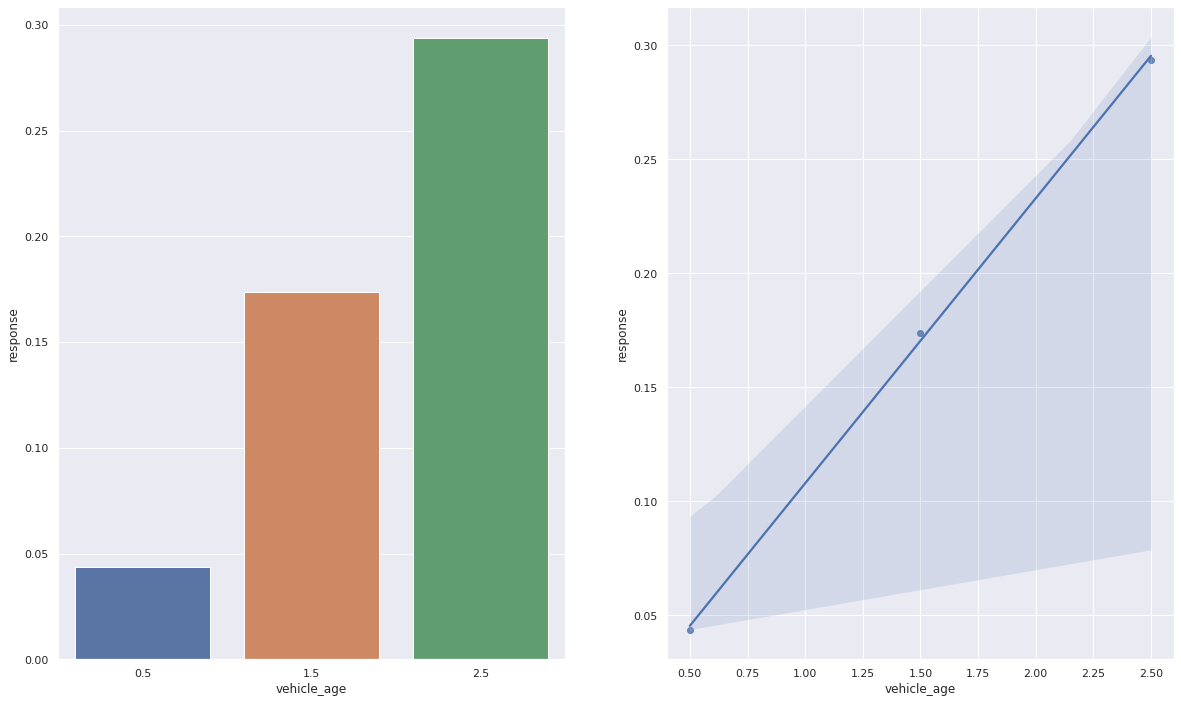

In [41]:
# vehicle_age x response
aux = df4[['vehicle_age', 'response']].groupby('vehicle_age').mean().reset_index()

plt.subplot(1, 2, 1)
sns.barplot(data=aux, x='vehicle_age', y='response')

plt.subplot(1, 2, 2)
sns.regplot(data=aux, x='vehicle_age', y='response')

### 3.2.7 H7: Clientes com veículos que já foram danificados tem mais interesse em obter seguro de automóvel.
**Verdade** Clientes com veículos que já foram danificados tem MUITO mais interesse em obter seguro de automóvel.


<AxesSubplot:xlabel='vehicle_damage', ylabel='response'>

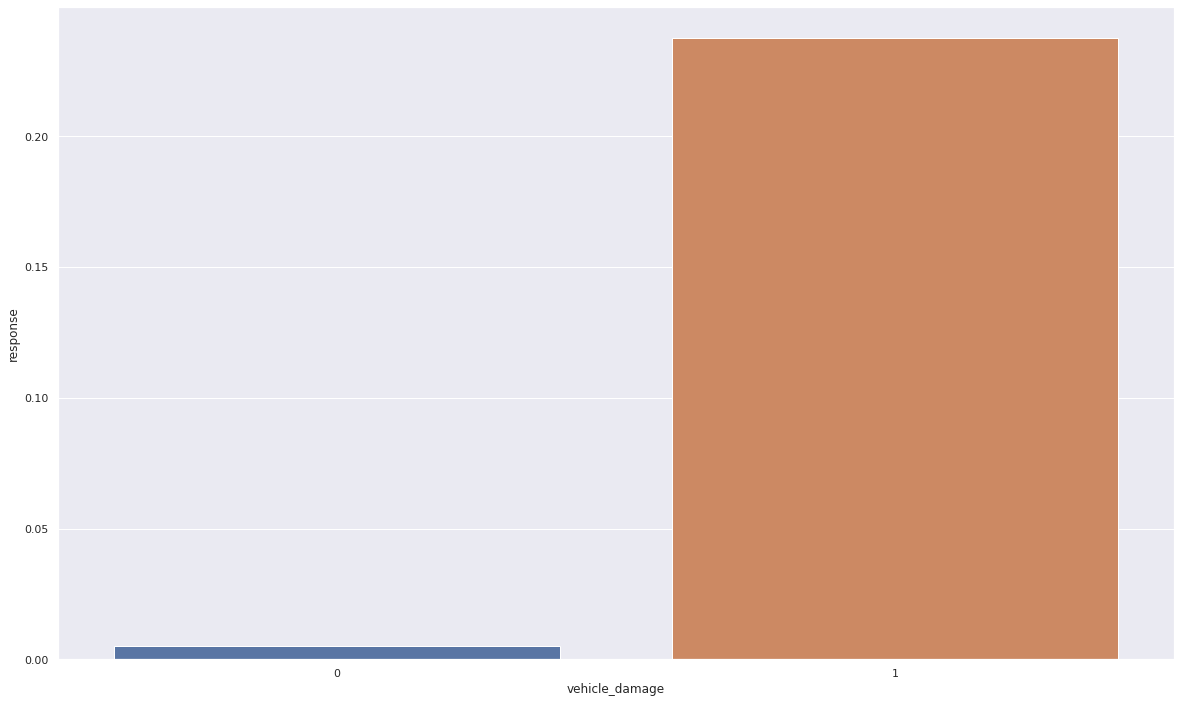

In [47]:
# vehicle_damage x response
aux = df4[['vehicle_damage', 'response']].groupby('vehicle_damage').mean().reset_index()

sns.barplot(data=aux, x='vehicle_damage', y='response')

### 3.2.8 H8: Clientes que já possuem seguro de automóvel em outra seguradora possuem menos interesse em obter seguro de automóvel.
**Verdade** Clientes que já possuem seguro de automóvel em outra seguradora possuem EXTREMAMENTE MENOS interesse em obter um novo seguro.

<AxesSubplot:xlabel='previously_insured', ylabel='response'>

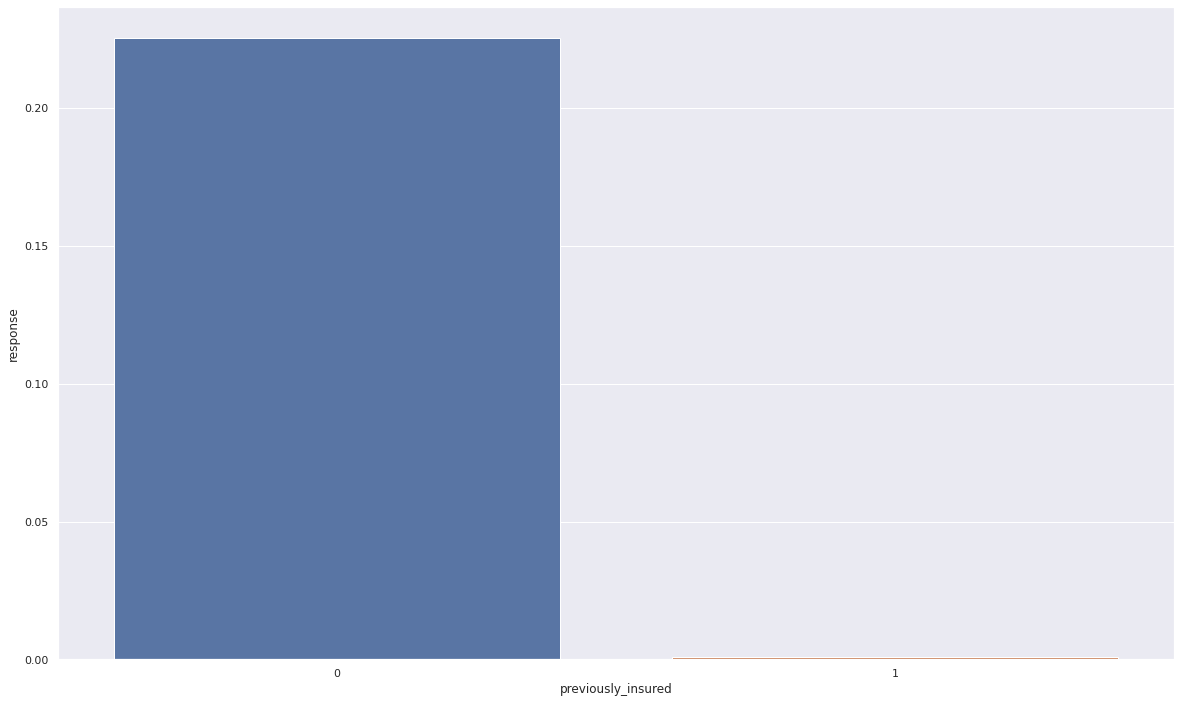

In [50]:
# previously_insured x response
aux = df4[['previously_insured', 'response']].groupby('previously_insured').mean().reset_index()

sns.barplot(data=aux, x='previously_insured', y='response')

## 3.3 Análise Multivariada

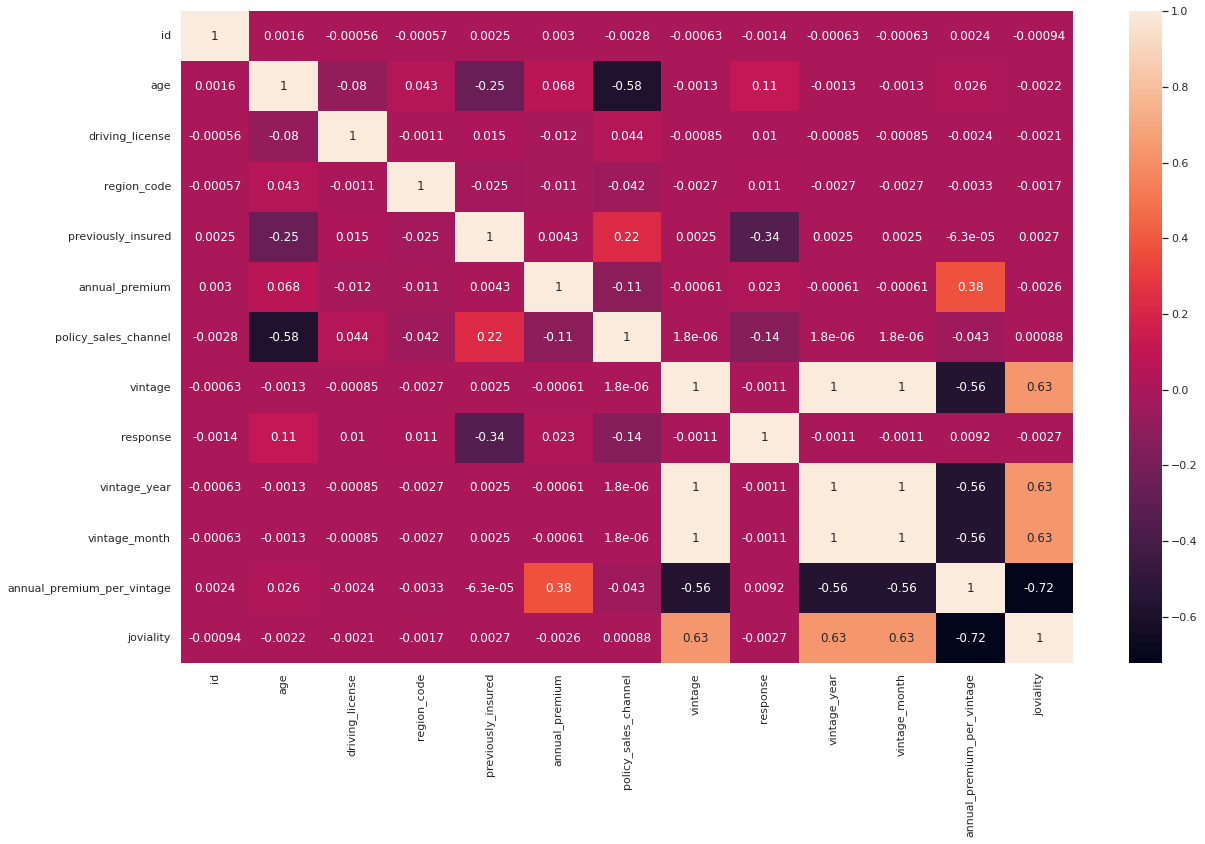

In [38]:
num_attributes = df3.select_dtypes(include=['int64', 'float64'])

sns.heatmap(num_attributes.corr(method='pearson'), annot=True);

<AxesSubplot:>

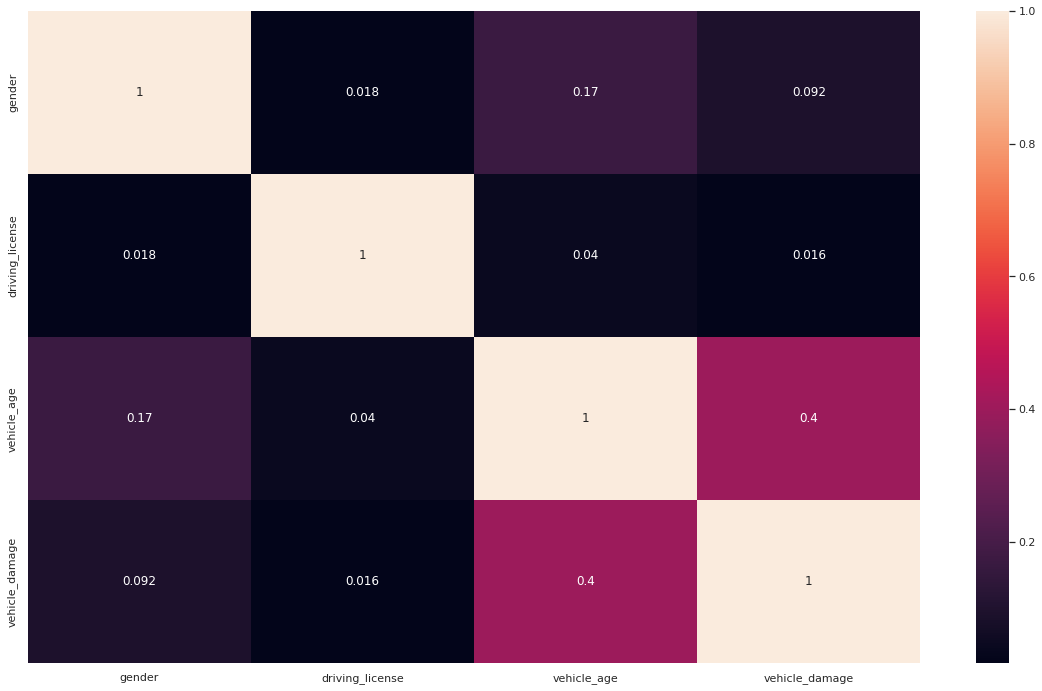

In [47]:
cat = df3.copy()

cat_list = ['gender', 'driving_license', 'vehicle_age', 'vehicle_damage', ]
cat_dic = {}

for c1 in cat_list:
    for c2 in cat_list:
        v = cramer_v(cat[c1], cat[c2])
        
        if cat_list.index(c2) == 0:
            cat_dic[c1] = []
            cat_dic[c1].append(v)
            
        else:
            cat_dic[c1].append(v)

cramer_v_table = pd.DataFrame(cat_dic)
cramer_v_table.set_index(cramer_v_table.columns, inplace=True)

sns.heatmap(cramer_v_table, annot=True)

Vehicle_damage possui uma correlação boa com vehicle_age.

# 4 Preparação dos Dados

In [14]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.2, random_state=42)

df5 = pd.concat([X_train, y_train], axis=1)

## 5.1 Padronização

In [15]:
ss = pp.StandardScaler() 

# annual_premium (pois a distribuição é próxima da normal. Não estamos tratando os outliers)
df5['annual_premium'] = ss.fit_transform(df5[['annual_premium']].values)
pickle.dump(ss, open('parameter/annual_premium_scaler.pkl', 'wb'))

## 5.2 Rescaling

In [16]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()
# mms_vintage_year = pp.MinMaxScaler()
# mms_vintage_month = pp.MinMaxScaler()
# rs_annual_premium_per_vintage = pp.RobustScaler()

# age (pois a distribuição não é próxima da normal)
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('parameter/age_scaler.pkl', 'wb'))

# vintage (pois a distribuição não é próxima da normal)
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values) 
pickle.dump(mms_vintage, open('parameter/vintage_scaler.pkl', 'wb'))

# vintage_year
# df5['vintage_year'] = mms_vintage.fit_transform(df5[['vintage_year']].values) 

# month
# df5['vintage_month'] = mms_vintage.fit_transform(df5[['vintage_month']].values) 

# annual_premium_per_vintage (pois a distruição possui muitos outliers)
# df5['annual_premium_per_vintage'] = rs_annual_premium_per_vintage.fit_transform(df5[['annual_premium_per_vintage']].values)

## 5.3 Enconder

In [17]:
# region_code - Target Encoding (escolhido) / Frequency Encoding / Weight Target Encoding
target_encode_region_code = df5.groupby('region_code')['response'].mean()
df5['region_code'] = df5['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('parameter/target_encode_region_code.pkl', 'wb'))

# vehicle_damage -  One Hot Encoding (escolhido) / Frequency Encoding / Target Encoding / Weight Target Encoding
df5['vehicle_damage'] = df5['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

# policy_sales_channel - Frequency Encoding / One Hot Encoding / Target Encoding / Weight Target Encoding
fe_encode_policy = df5.groupby('policy_sales_channel').size() / len(df5)
df5['policy_sales_channel'] = df5['policy_sales_channel'].map(fe_encode_policy)
pickle.dump(fe_encode_policy, open('parameter/fe_encode_policy.pkl', 'wb'))

# vehicle_age (One Hot Enconding)
# df5 = pd.get_dummies(df5, prefix='vehicle_age', columns=['vehicle_age'])

# vehicle_age (Target Encoding)
target_encode_vehicle_age = df5.groupby('vehicle_age')['response'].mean()
df5['vehicle_age'] = df5['vehicle_age'].map(target_encode_vehicle_age)
pickle.dump(target_encode_vehicle_age, open('parameter/target_encode_vehicle_age.pkl', 'wb'))

# gender
df5['gender'] = df5['gender'].apply(lambda x: 1 if x == 'Male' else 0)

In [18]:
df5.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
joviality               0
response                0
dtype: int64

## 5.4 Validação da Preparação

In [19]:
# annual premium
X_test['annual_premium'] = ss.transform(X_test[['annual_premium']].values)

# age
X_test['age'] = mms_age.transform(X_test[['age']].values)

# vintage 
X_test['vintage'] = mms_vintage.transform(X_test[['vintage']].values)

# region_code
X_test['region_code'] = X_test['region_code'].map(target_encode_region_code)

# vehicle_damage
# X_test = pd.get_dummies(X_test, prefix='vehicle_damage', columns=['vehicle_damage'])

# policy_sales_channel
X_test['policy_sales_channel'] = X_test['policy_sales_channel'].map(fe_encode_policy)

# vehicle_age
# X_test = pd.get_dummies(X_test, prefix='vehicle_age', columns=['vehicle_age'])

# vehicle_age
X_test['vehicle_age'] = X_test['vehicle_age'].map(target_encode_vehicle_age)

# gender
X_test['gender'] = X_test['gender'].apply(lambda x: 1 if x == 'Male' else 0)

# vehicle_damage -  One Hot Encoding (escolhido) / Frequency Encoding / Target Encoding / Weight Target Encoding
X_test['vehicle_damage'] = X_test['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

X_test = X_test.fillna(0)

# X_test.head()

In [20]:
X_test.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
joviality               0
dtype: int64

# 5 Seleção dos Atributos

In [13]:
# # model definition
# forest = en.ExtraTreesClassifier(n_estimators=250, random_state=42, n_jobs=-1)

# # data preparation
# X_train_n = df5.drop(['id', 'response'], axis=1)
# y_train_n = y_train.values
# forest.fit(X_train_n, y_train_n)


In [16]:
# importances = forest.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
# indices = np.argsort(importances)[::-1]

# # print the feature ranking
# print('Feature ranking:')
# df = pd.DataFrame()
# for i,j in zip(X_train_n, forest.feature_importances_):
#     aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
#     df = pd.concat([df, aux], axis=0)
    
# print(df.sort_values('importance', ascending=False))

# # plot the imputity-based feature importances of the forest
# plt.figure()
# plt.title('Feature importances')
# plt.bar(range(X_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
# plt.xticks(range(X_train.shape[1]), indices)
# plt.xlim([-1, X_train_n.shape[1]])
# plt.show()

# 6 Machine Learning

In [21]:
X_test2 = X_test.copy()

cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured', 'vehicle_age']

X_train = df5[cols_selected]
X_test = X_test[cols_selected]

## 7.1 KNN

In [157]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model_training
knn_model.fit(X_train, y_train)

# model prediction - Poder de Generalização
yhat_knn = knn_model.predict_proba(X_test)

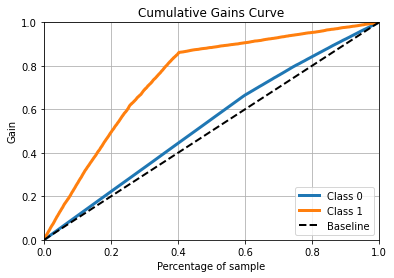

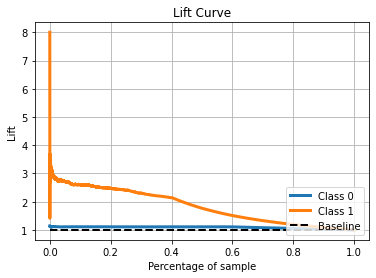

In [158]:
# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_knn);

# curva lift
skplt.metrics.plot_lift_curve(y_test, yhat_knn);

## 7.2 Regressão Logística

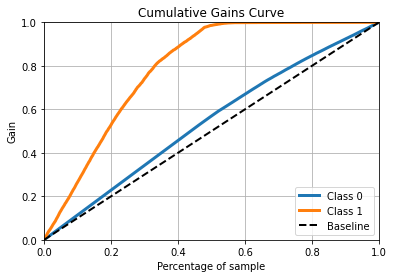

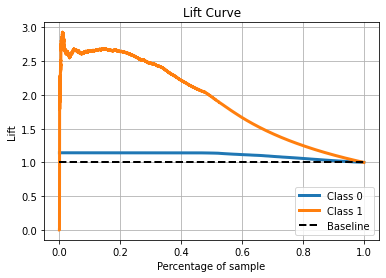

In [159]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(X_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(X_test)

# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_lr);

# curva lift
skplt.metrics.plot_lift_curve(y_test, yhat_lr);

## 7.3 Extra Tree

In [160]:
#  model
et = en.ExtraTreesClassifier(n_estimators = 100, n_jobs=-1, random_state=42)

# model training
et.fit(X_train, y_train)

# model prediction
yhat_et = et.predict_proba(X_test)


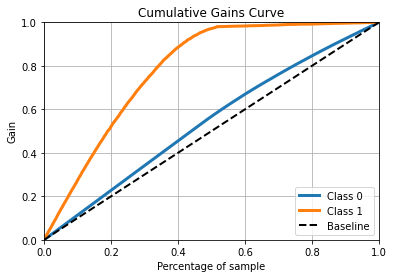

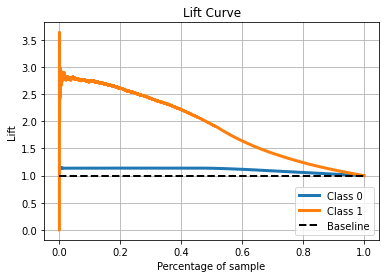

In [161]:
# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_et);

# curva lift
skplt.metrics.plot_lift_curve(y_test, yhat_et);

## 7.4 Random Forest

In [162]:
# model
rf = en.RandomForestClassifier(random_state=42)

# model training
rf.fit(X_train, y_train)

# predict
yhat_rf = rf.predict_proba(X_test)

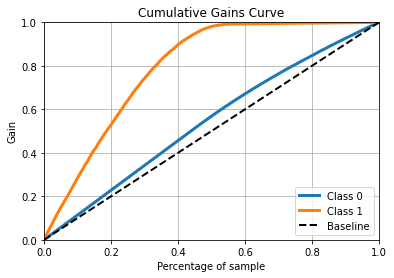

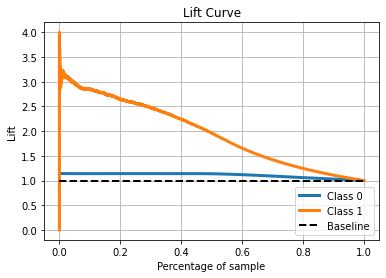

In [163]:
# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_rf);

# curva lift
skplt.metrics.plot_lift_curve(y_test, yhat_rf);

## 7.5 Light Gradient Boost Machine (LGBM)

In [22]:
# model
lgbm_model = LGBMClassifier(random_state=42)

# model training
lgbm_model.fit(X_train, y_train)

# predict
yhat_lgbm = lgbm_model.predict_proba(X_test)
pickle.dump(lgbm_model, open('model/lgbm_model.pkl', 'wb'))

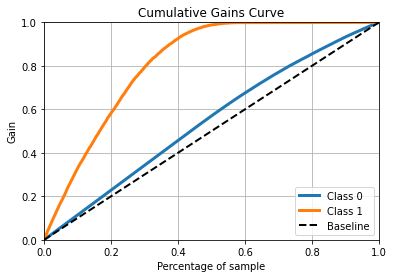

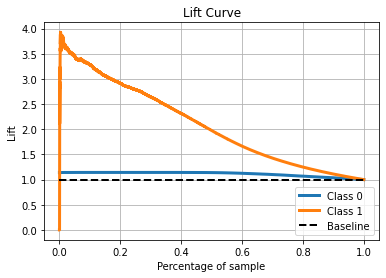

In [23]:
# ganho acumulado
skplt.metrics.plot_cumulative_gain(y_test, yhat_lgbm);

# curva lift
skplt.metrics.plot_lift_curve(y_test, yhat_lgbm);

# 7 Performance do Modelo

In [25]:
# data copy
df8 = pd.concat([X_test2['id'], X_test], axis=1)
df8['response'] = y_test.copy()
df8 = df8.reset_index(drop=True)

## 7.1 KNN

In [167]:
precision_at, recall_at = performance(df8, yhat_knn, k=2000)
print(f'Precision at 2000: {precision_at}')
print(f'Recall at 2000: {recall_at}')


Precision at 2000: 0.3458270864567716
Recall at 2000: 0.07266617662501312


## 7.2 Regressão Logística

In [168]:
precision_at, recall_at = performance(df8, yhat_lr, k=2000)
print(f'Precision at 2000: {precision_at}')
print(f'Recall at 2000: {recall_at}')


Precision at 2000: 0.3293353323338331
Recall at 2000: 0.06920088207497638


## 7.3 Extra Tree

In [169]:
precision_at, recall_at = performance(df8, yhat_et, k=2000)
print(f'Precision at 2000: {precision_at}')
print(f'Recall at 2000: {recall_at}')



Precision at 2000: 0.3493253373313343
Recall at 2000: 0.07340123910532395


## 7.4 Random Forest

In [170]:
precision_at, recall_at = performance(df8, yhat_rf, k=2000)
print(f'Precision at 2000: {precision_at}')
print(f'Recall at 2000: {recall_at}')


Precision at 2000: 0.383808095952024
Recall at 2000: 0.08064685498267353


## 7.5 Light Gradient Boost Machine

In [60]:
precision_at, recall_at = performance(df8, yhat_lgbm, k=6000)
print(f'Precision at 12000: {precision_at}')
print(f'Recall at 12000: {recall_at}')


Precision at 12000: 0.41843026162306285
Recall at 12000: 0.2636774125800693


## 7.6 Cross-Validation

### 7.6.1 Cross-Validation KNN


In [38]:
model = nh.KNeighborsClassifier(n_neighbors=7)
df_knn = cross_validation(df4, model, 'KNN', iterations=5)
df_knn

,Modelo,Precision at 2000 CV,Recall at 2000 CV
0,KNN,0.3424 +/- 0.0102,0.0735 +/- 0.0022


### 7.6.2 Cross-Validation Logistic Regression

In [39]:
model = lm.LogisticRegression(random_state=42)
df_lr = cross_validation(df4, model, 'Logistic Regression', iterations=10)
df_lr

,Modelo,Precision at 2000 CV,Recall at 2000 CV
0,Logistic Regression,0.3273 +/- 0.0058,0.0699 +/- 0.0013


### 7.6.3 Cross-Validation Extra Tree

In [40]:
model = en.ExtraTreesClassifier(n_estimators = 100, n_jobs=-1, random_state=42)
df_et = cross_validation(df4, model, 'Extra Tree', iterations=5)
df_et

,Modelo,Precision at 2000 CV,Recall at 2000 CV
0,Extra Tree,0.3423 +/- 0.0115,0.0732 +/- 0.0019


### 7.6.4 Cross-Validation Random Forest

In [41]:
model = en.RandomForestClassifier(random_state=42)
df_rf = cross_validation(df4, model, 'Random Forest', iterations=5)
df_rf

,Modelo,Precision at 2000 CV,Recall at 2000 CV
0,Random Forest,0.3684 +/- 0.0041,0.0785 +/- 0.001


### 7.6.5 Cross-Validation LGBM

In [42]:
model = LGBMClassifier(random_state=42)
df_lgbm = cross_validation(df4, model, 'LGBM', iterations=10)
df_lgbm

,Modelo,Precision at 2000 CV,Recall at 2000 CV
0,LGBM,0.4439 +/- 0.0094,0.0947 +/- 0.0017


### 7.6.6 Resultado do Cross Validation

In [43]:
pd.concat([df_knn, df_lr, df_et, df_rf, df_lgbm])

,Modelo,Precision at 2000 CV,Recall at 2000 CV
0,KNN,0.3424 +/- 0.0102,0.0735 +/- 0.0022
0,Logistic Regression,0.3273 +/- 0.0058,0.0699 +/- 0.0013
0,Extra Tree,0.3423 +/- 0.0115,0.0732 +/- 0.0019
0,Random Forest,0.3684 +/- 0.0041,0.0785 +/- 0.001
0,LGBM,0.4439 +/- 0.0094,0.0947 +/- 0.0017


Mais uma vez o LGBM se mostrou com uma performance melhor do que os outros, então a partir de agora manteremos o projeto apenas com esse modelo.

In [45]:
df4.shape[0] * 0.2

76221.8

# 8 Fine Tunning

Referência:
https://towardsdatascience.com/kagglers-guide-to-lightgbm-hyperparameter-tuning-with-optuna-in-2021-ed048d9838b5

http://hyperopt.github.io/hyperopt/


num_leaves
min_data_in_leaf
n_estimators 
learning_rate (0.01 - 0.3)
lambda_l1 (0 - 100)
lambda_l2 (0 - 100)

# 9 Deploy do Modelo em Produção

## 9.1 Classe HealthInsurance

In [49]:
import pickle
import pandas as pd
import numpy as np

class HealthInsurance(object):
    
    def __init__(self):
        self.path = '/home/jonas/Documentos/repos/health_insurance_cross_sell/parameter/'
        self.age_scaler                = pickle.load(open(self.path + 'age_scaler.pkl', 'rb'))
        self.annual_premium_scaler     = pickle.load(open(self.path + 'annual_premium_scaler.pkl', 'rb'))
        self.fe_encode_policy          = pickle.load(open(self.path + 'fe_encode_policy.pkl', 'rb'))
        self.target_encode_region_code = pickle.load(open(self.path + 'target_encode_region_code.pkl', 'rb'))
        self.target_encode_vehicle_age = pickle.load(open(self.path + 'target_encode_vehicle_age.pkl', 'rb'))
        self.vintage_scaler            = pickle.load(open(self.path + 'vintage_scaler.pkl', 'rb'))
    
    def data_cleaning(self, data):
        data.columns = data.columns.str.lower()
        
        return data
    
    def feature_engineering(self, data):
        # vehicle_age
        data['vehicle_age'] = data['vehicle_age'].apply(lambda x: 'less_than_1' if x == '< 1 Year' else 
                                                                'between_1_2' if x == '1-2 Year' else
                                                                'more_than_2')
        
        # age
        data['joviality'] = data['vintage'].apply(lambda x: 1 if x < 25 else 0)

        return data
    
    def data_preparation(self, data):
        
        ## annual premium
        data['annual_premium'] = self.annual_premium_scaler.transform(data[['annual_premium']].values)

        # age
        data['age'] = self.age_scaler.transform(data[['age']].values)

        # vintage 
        data['vintage'] = self.vintage_scaler.transform(data[['vintage']].values)

        # region_code
        data['region_code'] = data['region_code'].map(self.target_encode_region_code)

        # policy_sales_channel
        data['policy_sales_channel'] = data['policy_sales_channel'].map(self.fe_encode_policy)

        # vehicle_age
        data['vehicle_age'] = data['vehicle_age'].map(self.target_encode_vehicle_age)

        # gender
        data['gender'] = data['gender'].apply(lambda x: 1 if x == 'Male' else 0)

        # vehicle_damage -  One Hot Encoding (escolhido) / Frequency Encoding / Target Encoding / Weight Target Encoding
        data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

        data = data.fillna(0)
        
        # colunas selecionadas    
        cols_selected = ['vintage', 'annual_premium', 'age', 'region_code', 'vehicle_damage', 'policy_sales_channel', 'previously_insured', 'vehicle_age']
        

        return data[cols_selected]

    def get_prediction(self, model, original_data, test_data):
        # model predition
        pred = model.predict_proba(test_data)
        
        # join prediction into original data
        original_data['score'] = pred[:, 1]
        
        return original_data.to_json(orient='records', date_format='iso')   

## 9.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from healthinsurance.HealthInsurance import HealthInsurance
import numpy

path = '/home/jonas/Documentos/repos/health_insurance_cross_sell/'
model = pickle.load(open(path + 'model/random_forest.pkl', 'rb'))

# inicialização da API
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    print('entrou 0')
    if test_json:  # se existir data
        print(type(test_json))
        print(test_json)
        if isinstance(test_json, dict): # se for uma única linha
            print('entrou 2')
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else: # se for múltiplas linhas
            print('entrou 3')
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())            
            
        # instanciando a Classe HealthInsurance
        pipeline = HealthInsurance()
        
        # limpeza dos dados
        df1 = pipeline.data_cleaning(test_raw)
        
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        # preparação dos dados
        df3 = pipeline.data_preparation(df2)
        
        # predição
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    
    
if __name__ == '__main__':
    app.run('0.0.0.0', debug=True)

## 9.3 API Tester

In [38]:
import requests

In [39]:
# loading conjunto de dados de teste
df_test_raw = pd.read_csv('/home/jonas/Documentos/repos/health_insurance_cross_sell/datasets/test.csv')
# df_test_raw = df_test_raw.sample(10)

In [40]:
df_test_id = df_test_raw['id'].copy()
df_test = df_test_raw.drop('id', axis=1)

In [41]:
# converter o dataframe para json
data = json.dumps(df_test.to_dict(orient='records')) 

In [42]:
# API Call
url = 'http://0.0.0.0:5000/predict'

header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, headers=header, data=data)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [43]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
df_result = pd.concat([df_test_raw, d1['score']], axis=1).sort_values('score', ascending=False).reset_index(drop=True)

# 10 Resultados do Negócio

In [54]:
# Com as 20000 primeiras pessoas espera-se atingir 46,52% de todos os interessados
df_result['score'].head(10000).sum() / df_result['score'].sum() ## Isso é tipo o Recall at k?

0.2557408449586079

In [45]:
# comparando com o modelo aleatório
20000 / df_result.shape[0]

0.15743444823161756

In [46]:
(df_result['score'].head(20000).sum() / df_result['score'].sum() ) / (20000 / df_result.shape[0]) - 1

1.9726701537474738

Para as 20000 primeiras ligações o modelo aleatório atingirá 15,74% do interessados, enquanto a nossa solução atinge 46,52%. Essa diferença percentual significa um aumento de 195,46% no faturamento.

In [47]:
# Com as 40000 primeiras pessoas espera-se atingit 80,47% de todos os interessados
df_result['score'].head(40000).sum() / df_result['score'].sum()   ## Isso é tipo o Recall at k?

0.8057839723100624

In [48]:
# comparando com o modelo aleatório
40000 / df_result.shape[0]

0.3148688964632351

In [49]:
(df_result['score'].head(40000).sum() / df_result['score'].sum() ) / (40000 / df_result.shape[0]) - 1

1.5591094622588346

Para as 40000 primeiras ligações o modelo aleatório atingirá 31,48% do interessados, enquanto a nossa solução atinge 80,46%. Essa diferença percentual significa um aumento de 155,55% no faturamento.

In [50]:
df_result['rank'] = df_result.index + 1

In [51]:
df_result['score_cum_percentege'] = df_result['score'].cumsum() / df_result['score'].sum() 

In [52]:
df_result[(df_result['score_cum_percentege'] > 0.79999) & (df_result['score_cum_percentege'] < 0.80001)]

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,score,rank,score_cum_percentege
39561,432257,Female,59,1,28.0,0,1-2 Year,Yes,33397.0,124.0,74,0.206895,39562,0.799994
39562,406254,Male,58,1,33.0,0,1-2 Year,Yes,2630.0,124.0,93,0.206893,39563,0.800007


Para atingir 80% dos interessados é necessário contatar 39650 clientes

# Referências

1. Gráficos: 

- https://www.python-graph-gallery.com/

- https://www.python-graph-gallery.com/stacked-and-percent-stacked-barplot

2. Sobre as métricas de Ranking

- https://queirozf.com/entries/evaluation-metrics-for-ranking-problems-introduction-and-examples

- https://stats.stackexchange.com/questions/159657/metrics-for-evaluating-ranking-algorithms

- https://archive.siam.org/meetings/sdm10/tutorial1.pdf

- https://brianmcfee.net/papers/mlr.pdf


3. Curvas Ranking e Lift

- https://towardsdatascience.com/meaningful-metrics-cumulative-gains-and-lyft-charts-7aac02fc5c14


4. Exemplos de Problemas de Métrica

- https://towardsdatascience.com/20-popular-machine-learning-metrics-part-2-ranking-statistical-metrics-22c3e5a937b6


5. Bias and Variance
Book Machine Learning: An Algorithmic Perspective, by Stephen Marsland - Capítulo 02
YouTube: StatQuest


6. Random Forest Model
Book Machine Learning: An Algorithmic Perspective, by Stephen Marsland - Capítulo 13
https://stats.stackexchange.com/questions/262794/why-does-a-decision-tree-have-low-bias-high-variance


7. Paper Original da Random Forest
https://link.springer.com/article/10.1023/A:1010933404324

